In [1]:
import os
import clip
import torch
from PIL import Image
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from tqdm import tqdm
print(f'{torch.__version__}')

1.7.1


In [6]:
csv_path = 'label.csv'
img_root = './training'


In [10]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import random
# 若沒有使用外部transform, 則需要自己將feature和label轉為torch.tensor
# 要注意pytorch的影像格式是(3, 224, 224), 跟其他不一樣
# 圖片照類別分在不同資料夾, 因此CSV中的檔名已經是完整路徑
class CustomDatasetFromImages(Dataset):
    def __init__(self, csv_path, img_root, transform=None):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Transforms
        self.transform = transform
        # Read the csv file
        self.data_info = pd.read_csv(csv_path)
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.iloc[:, 1])
        
        # Calculate len
        self.data_len = len(self.data_info.index)
        print(f'Data_shape: {self.data_len}')

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        single_image_name = os.path.join(img_root, single_image_name) # csv檔名若已經是完整路徑, 不用再加
        # Open image
        img = Image.open(single_image_name)
        
        # If there is an transform
        if self.transform:
            img = self.transform(img)
        
        # Transform image to tensor
#         img_as_tensor = self.to_tensor(img_as_img)
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        return (img, single_image_label)

    def __len__(self):
        return self.data_len


In [8]:
# Linear Probe 只用image-encoder, 沒用到text-encoder
def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

In [4]:
# Load the model, 可改其他model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)
# model, preprocess = clip.load('ViT-L/14', device) 

In [11]:
# Call dataset
dataset =  CustomDatasetFromImages(csv_path=csv_path, img_root=img_root, transform=preprocess)
# 測試讀取dataset中資料
cnt = 0
for image, label in DataLoader(dataset, batch_size=1):
    print(label)
    cnt += 1
    if cnt == 5:
        break

Data_shape: 2190
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])


In [12]:
import time
# Calculate the image features
start = time.time()
features, labels = get_features(dataset)
end = time.time()
print(f'Time: {end-start}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:47<00:00,  2.16s/it]

Time: 47.648163080215454


In [13]:
# np.save('Subdata_features_ViTB32', features)
# np.save('Subdata_labels_ViTB32', labels)
np.save('features_ViTB32', features)
np.save('labels_ViTB32', labels)

## 分類器訓練

### Pipeline實驗
- 先用pipe.get_params() 查看各個paramaters的名稱，構成pipeline後會更名

In [14]:
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
# 前處理
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.decomposition import PCA
# 模型
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

train_features = np.load('features_ViTB32.npy')
train_labels = np.load('labels_ViTB32.npy')
x_train, x_test, y_train, y_test = train_test_split(train_features, train_labels, 
                                                    test_size = 0.3, random_state = 0,
                                                    stratify=train_labels)

# 資料前處理
# 標準化
standardize = StandardScaler()
pca = PCA()

# 模型
clf_LG = LogisticRegression(random_state=1)
clf_SVC = SVC(random_state=1)
clf_RFC = RandomForestClassifier(random_state=1)
clf_dict = {
    'LG': clf_LG,
#     'SVC': clf_SVC,
#     'RFC':clf_RFC
} 

# Parameters Search Space
param_grid_LG = {
    'LG__penalty': ['l2'],
    'LG__max_iter': [5000, 10000],
    'LG__C': np.arange(0.1, 1.0, 0.1).tolist()
}
param_grid_RFC = {
    'RFC__n_estimators': [100, 200]
}
param_dict = {
    'LG': param_grid_LG,
    'RFC': param_grid_RFC
}

best_model = {}
best_score = 0.0
for clf_id, clf in clf_dict.items():
    pipe = Pipeline(steps=[(clf_id, clf)], verbose=1)
    print(pipe.get_params())
    search = GridSearchCV(pipe, param_dict[clf_id],
                          cv=5,
                          return_train_score=True,
                          scoring=['accuracy', 'f1_micro'], # search.score會使用第一個metric
                          refit='f1_micro')
    search.fit(x_train, y_train)
    
    if search.score(x_test, y_test) > best_score: # 挑模型
        best_model = search.best_params_
        best_score = search.score(x_test, y_test)
        best_estimator = search.best_estimator_.get_params()
    print(f'Parameter (CV score={search.best_score_}): {search.best_params_}')
    print(f'{clf_id} Score on TestData: {search.score(x_test, y_test)}')
    print('****************************************************************************\n')
print(f'Best Model: {best_model}\n')
print(f'Best test score: {best_score}')

{'memory': None, 'steps': [('LG', LogisticRegression(random_state=1))], 'verbose': 1, 'LG': LogisticRegression(random_state=1), 'LG__C': 1.0, 'LG__class_weight': None, 'LG__dual': False, 'LG__fit_intercept': True, 'LG__intercept_scaling': 1, 'LG__l1_ratio': None, 'LG__max_iter': 100, 'LG__multi_class': 'auto', 'LG__n_jobs': None, 'LG__penalty': 'l2', 'LG__random_state': 1, 'LG__solver': 'lbfgs', 'LG__tol': 0.0001, 'LG__verbose': 0, 'LG__warm_start': False}
[Pipeline] ................ (step 1 of 1) Processing LG, total=   3.0s
[Pipeline] ................ (step 1 of 1) Processing LG, total=   2.5s
[Pipeline] ................ (step 1 of 1) Processing LG, total=   2.1s
[Pipeline] ................ (step 1 of 1) Processing LG, total=   2.2s
[Pipeline] ................ (step 1 of 1) Processing LG, total=   2.1s
[Pipeline] ................ (step 1 of 1) Processing LG, total=   2.7s
[Pipeline] ................ (step 1 of 1) Processing LG, total=   2.4s
[Pipeline] ................ (step 1 of 1) 

In [15]:
# 查看最佳模型完整參數
best_estimator

{'memory': None,
 'steps': [('LG', LogisticRegression(C=0.9, max_iter=5000, random_state=1))],
 'verbose': 1,
 'LG': LogisticRegression(C=0.9, max_iter=5000, random_state=1),
 'LG__C': 0.9,
 'LG__class_weight': None,
 'LG__dual': False,
 'LG__fit_intercept': True,
 'LG__intercept_scaling': 1,
 'LG__l1_ratio': None,
 'LG__max_iter': 5000,
 'LG__multi_class': 'auto',
 'LG__n_jobs': None,
 'LG__penalty': 'l2',
 'LG__random_state': 1,
 'LG__solver': 'lbfgs',
 'LG__tol': 0.0001,
 'LG__verbose': 0,
 'LG__warm_start': False}

In [16]:
search.best_model

AttributeError: 'GridSearchCV' object has no attribute 'best_model'

In [17]:
# 顯示全部實驗結果
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_LG__C,param_LG__max_iter,param_LG__penalty,params,split0_test_accuracy,split1_test_accuracy,...,mean_test_f1_micro,std_test_f1_micro,rank_test_f1_micro,split0_train_f1_micro,split1_train_f1_micro,split2_train_f1_micro,split3_train_f1_micro,split4_train_f1_micro,mean_train_f1_micro,std_train_f1_micro
0,2.388227,0.326160,0.003603,1.358259e-03,0.1,5000,l2,"{'LG__C': 0.1, 'LG__max_iter': 5000, 'LG__pena...",0.482085,0.511401,...,0.504269,0.032861,17,0.935563,0.951876,0.949429,0.951100,0.955990,0.948792,0.006958
1,2.325800,0.215839,0.003003,2.861023e-07,0.1,10000,l2,"{'LG__C': 0.1, 'LG__max_iter': 10000, 'LG__pen...",0.482085,0.511401,...,0.504269,0.032861,17,0.935563,0.951876,0.949429,0.951100,0.955990,0.948792,0.006958
2,2.933206,0.284187,0.003804,1.327769e-03,0.2,5000,l2,"{'LG__C': 0.2, 'LG__max_iter': 5000, 'LG__pena...",0.543974,0.560261,...,0.559053,0.018856,15,0.984502,0.985318,0.984502,0.988590,0.983700,0.985323,0.001712
3,2.990450,0.254600,0.002802,4.004718e-04,0.2,10000,l2,"{'LG__C': 0.2, 'LG__max_iter': 10000, 'LG__pen...",0.543974,0.560261,...,0.559053,0.018856,15,0.984502,0.985318,0.984502,0.988590,0.983700,0.985323,0.001712
4,3.377079,0.198672,0.003604,1.200748e-03,0.3,5000,l2,"{'LG__C': 0.30000000000000004, 'LG__max_iter':...",0.560261,0.570033,...,0.587113,0.020723,13,0.992659,0.995922,0.995922,0.994295,0.994295,0.994619,0.001220
5,3.461062,0.275573,0.003001,2.366957e-06,0.3,10000,l2,"{'LG__C': 0.30000000000000004, 'LG__max_iter':...",0.560261,0.570033,...,0.587113,0.020723,13,0.992659,0.995922,0.995922,0.994295,0.994295,0.994619,0.001220
6,4.434472,0.631783,0.003003,5.840039e-07,0.4,5000,l2,"{'LG__C': 0.4, 'LG__max_iter': 5000, 'LG__pena...",0.579805,0.573290,...,0.598205,0.022069,11,0.996737,0.999184,0.997553,0.998370,0.999185,0.998206,0.000951
7,4.201508,0.556164,0.002803,4.006386e-04,0.4,10000,l2,"{'LG__C': 0.4, 'LG__max_iter': 10000, 'LG__pen...",0.579805,0.573290,...,0.598205,0.022069,11,0.996737,0.999184,0.997553,0.998370,0.999185,0.998206,0.000951
8,4.281333,0.437429,0.003003,4.672031e-07,0.5,5000,l2,"{'LG__C': 0.5, 'LG__max_iter': 5000, 'LG__pena...",0.579805,0.573290,...,0.604079,0.025696,9,1.000000,1.000000,0.999184,1.000000,1.000000,0.999837,0.000326
9,4.362583,0.441656,0.003203,4.001143e-04,0.5,10000,l2,"{'LG__C': 0.5, 'LG__max_iter': 10000, 'LG__pen...",0.579805,0.573290,...,0.604079,0.025696,9,1.000000,1.000000,0.999184,1.000000,1.000000,0.999837,0.000326


### 以最佳模型參數建立模型

In [18]:
best_model_name = list(best_estimator.keys())[3]
best_model_name

'LG'

In [19]:
# 將被pipeline更名過的參數回復
# new_params = {}
# for key, value in search.best_params_.items():
#     new_params[key.split('__')[1]] = value 

clf_name = best_estimator[best_model_name]
best_clf = Pipeline(steps=[(best_model_name, clf_name)], verbose=1)
best_clf.fit(x_train, y_train)
best_clf.score(x_test, y_test)

[Pipeline] ................ (step 1 of 1) Processing LG, total=   6.5s


0.7092846270928462

### Evaluation

In [20]:
# Evaluate using the logistic regression classifier
predictions = best_clf.predict(x_test)
accuracy = np.mean((y_test == predictions).astype(np.float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

Accuracy = 70.928


C:\Users\user\AppData\Local\Temp\ipykernel_18564\3939716646.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracy = np.mean((y_test == predictions).astype(np.float)) * 100.


In [13]:
from sklearn.metrics import classification_report
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [14]:
target_names = ['banana', 'bareland', 'carrot', 'corn', 'dragonfruit', 'garlic',
                'guava', 'inundated', 'peanut', 'pineapple', 'pumpkin', 'rice',
                'soybean', 'sugarcane', 'tomato']
print(classification_report(y_test, predictions, target_names=target_names))
print ("**************************************************************")

              precision    recall  f1-score   support

      banana       0.97      0.96      0.97       122
    bareland       0.96      0.97      0.96       277
      carrot       0.93      0.92      0.92        60
        corn       0.94      0.98      0.96       290
 dragonfruit       0.97      0.97      0.97        59
      garlic       0.97      0.94      0.96       230
       guava       0.99      0.98      0.99       141
   inundated       0.96      0.95      0.96       102
      peanut       0.90      0.93      0.91       316
   pineapple       1.00      0.98      0.99       240
     pumpkin       0.98      0.92      0.95        50
        rice       0.97      0.99      0.98       239
     soybean       0.88      0.82      0.85       170
   sugarcane       0.97      0.97      0.97        66
      tomato       0.98      0.96      0.97        45

    accuracy                           0.95      2407
   macro avg       0.96      0.95      0.95      2407
weighted avg       0.95   

Normalized confusion matrix
[[0.95901639 0.00819672 0.         0.         0.00819672 0.
  0.         0.         0.00819672 0.         0.00819672 0.00819672
  0.         0.         0.        ]
 [0.00361011 0.97111913 0.00361011 0.         0.         0.00361011
  0.         0.01444043 0.00361011 0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.91666667 0.         0.         0.
  0.         0.         0.08333333 0.         0.         0.
  0.         0.         0.        ]
 [0.         0.00344828 0.         0.98275862 0.         0.00689655
  0.         0.         0.         0.         0.         0.
  0.00689655 0.         0.        ]
 [0.         0.01694915 0.         0.01694915 0.96610169 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.00434783 0.         0.03043478 0.         0.93913043
  0.         0.         0.00869565 0.         0.         0.00869565
  0.00434783 0.00434783 0.      

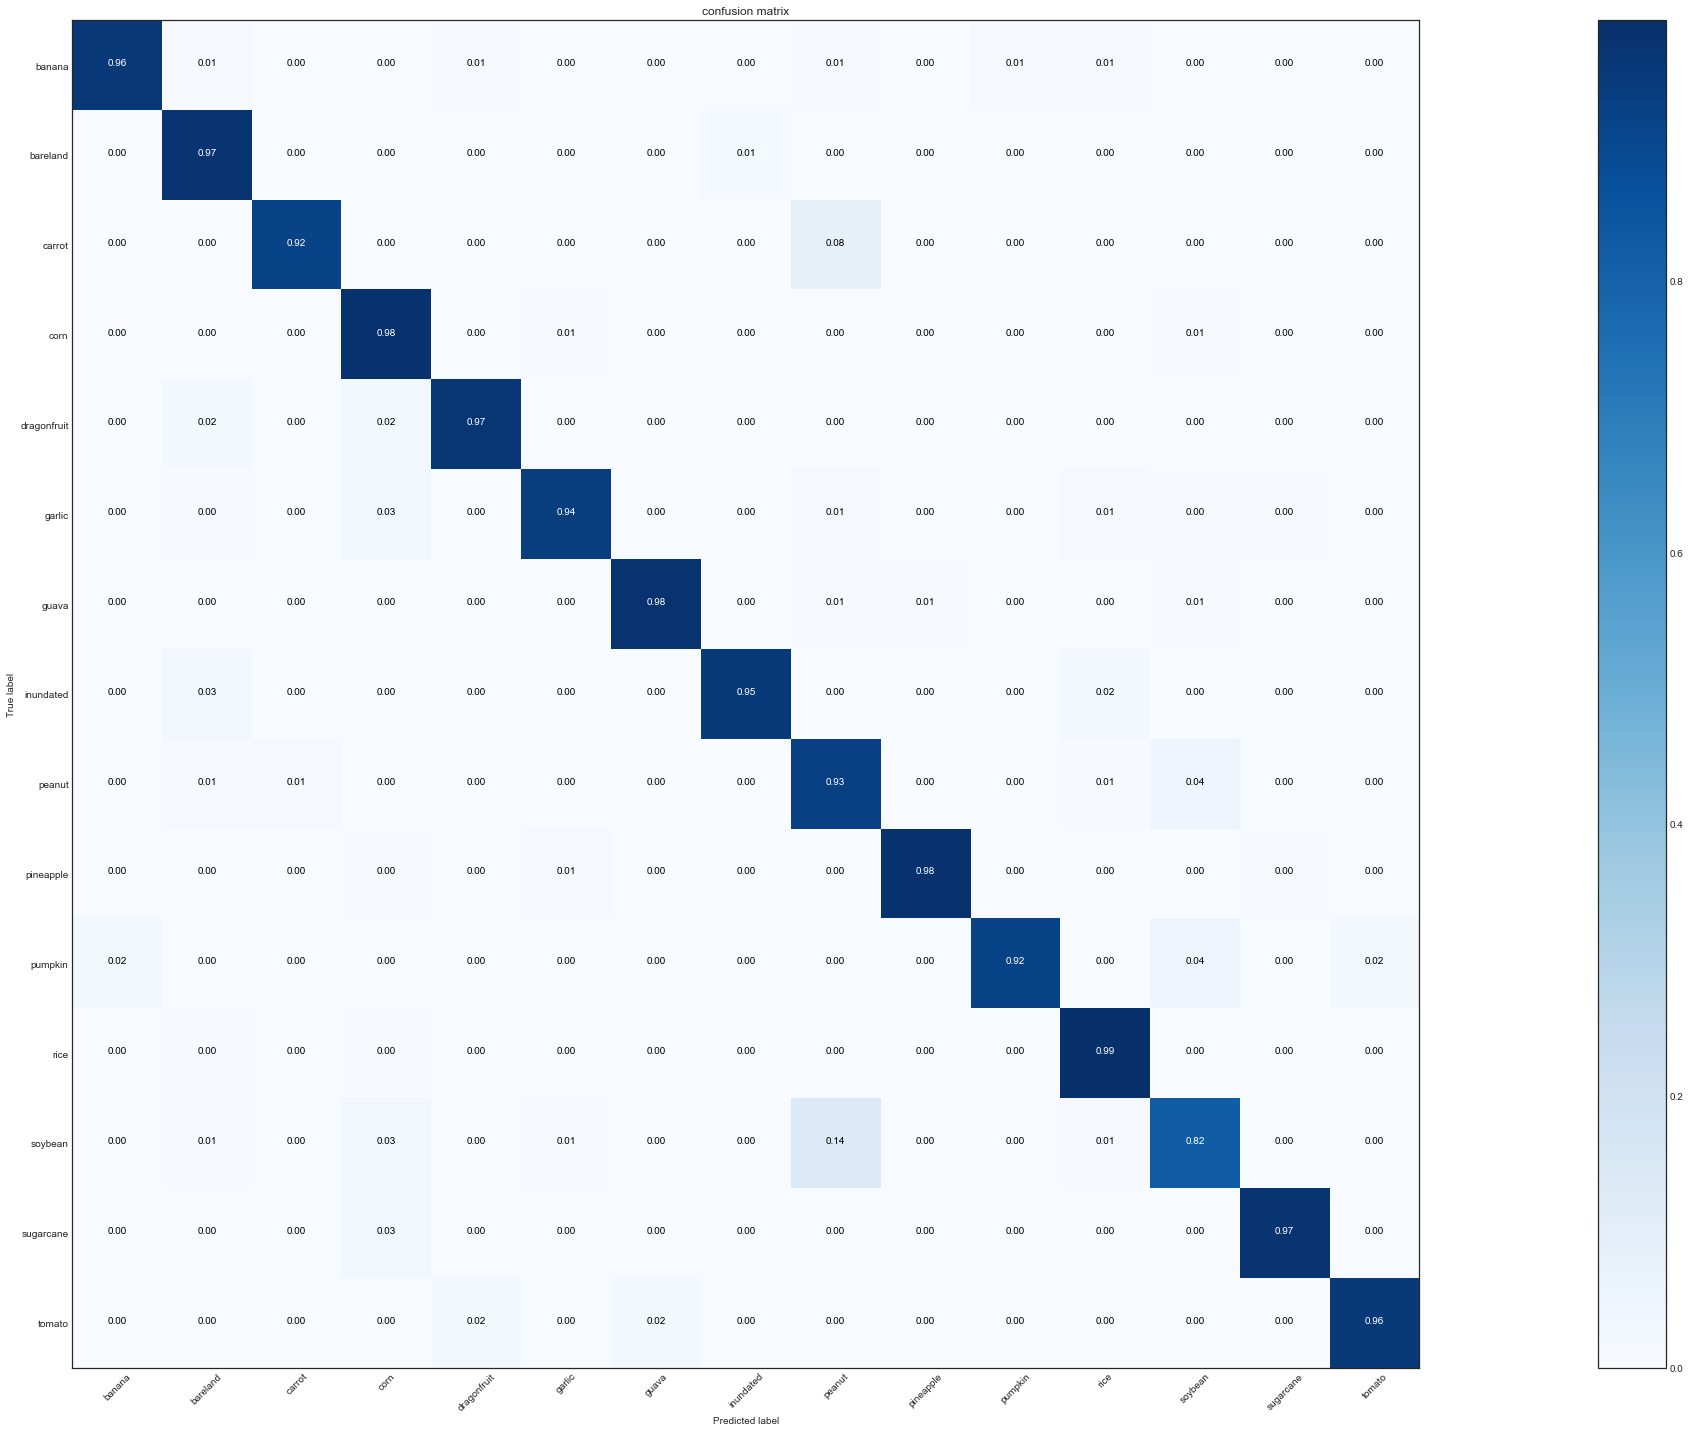

In [15]:
plt.style.use('seaborn-white')
plt.figure(figsize=(50, 20))
cnf_matrix = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cnf_matrix, classes=target_names,normalize=True,
                    title='confusion matrix')

## 實驗
- AllData(7:3), ViT_B/32, LG, iter=5000, C=0.9 : 70.9%
- 
